# Generate some dummy data

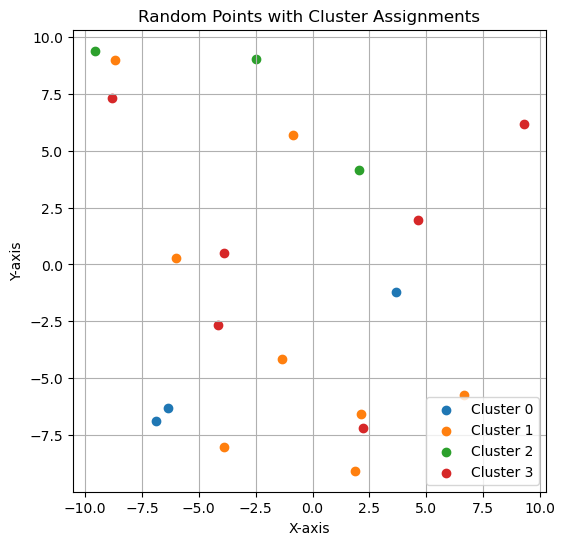

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for generating points
num_points = 20  # Total number of points
num_clusters = 4  # Number of clusters
x_range = (-10, 10)  # Range for x-axis
y_range = (-10, 10)  # Range for y-axis

# Generate random points and assign clusters
np.random.seed(42)  # For reproducibility
points = np.random.rand(num_points, 2)
points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]
clusters = np.random.randint(0, num_clusters, size=num_points)

# Scatter plot of points with cluster coloring
plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = points[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("Random Points with Cluster Assignments")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

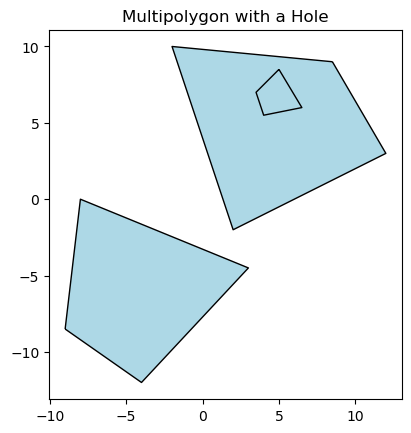

In [91]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Define the exterior coordinates of the polygons
polygon1_coords = [(-9, -8.5), (-8, 0), (3, -4.5), (-4, -12), (-9, -8.5)]  # A much larger complex polygon
polygon2_coords = [(8.5, 9), (12, 3), (2, -2), (-2, 10), (8.5, 9)]         # A much larger complex polygon
hole_coords = [(5, 8.5), (6.5, 6), (4, 5.5), (3.5, 7), (5, 8.5)]          # Enlarged hole inside polygon2

# Create polygons
polygon1 = Polygon(polygon1_coords)
polygon2 = Polygon(polygon2_coords, [hole_coords])  # Polygon with a hole

# Combine into a MultiPolygon
multipolygon = MultiPolygon([polygon1, polygon2])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame([{'geometry': multipolygon, 'id': 1}])

# Display the GeoDataFrame
gdf.plot(color='lightblue', edgecolor='black')
plt.title("Multipolygon with a Hole")
plt.gca().set_aspect('equal')
plt.show()

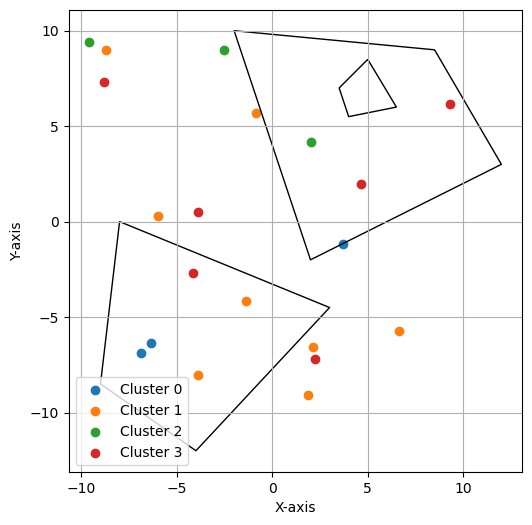

In [92]:
plt.figure(figsize=(8, 6))

# Scatter plot of the clusters
for cluster_id in range(num_clusters):
    cluster_points = points[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

# GeoDataFrame plot (overlaid)
gdf.plot(ax=plt.gca(), color='None', edgecolor='black')

# Add labels, legend, and grid
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)

# Ensure aspect ratio is equal
plt.gca().set_aspect('equal')

# Show the combined plot
plt.show()

# Voronoi

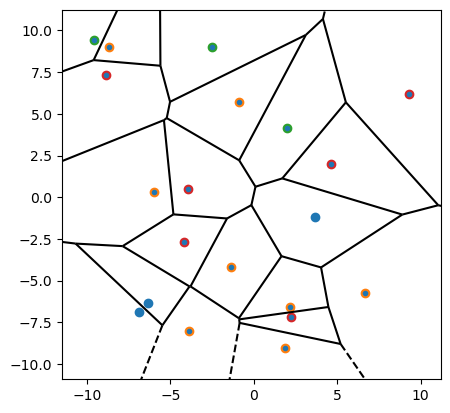

In [93]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(points)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5)
ax.set_aspect('equal')

# Scatter plot of the clusters
for cluster_id in range(num_clusters):
    cluster_points = points[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

In [94]:
gdf.geometry.bounds

,minx,miny,maxx,maxy
0,-9.0,-12.0,12.0,10.0


In [114]:
from shapely.geometry import Polygon
# extract valid polygons
voronoi_polygons = []
clustersPolygons = []

for i in range(len([region for region in vor.regions if region])):
    if -1 not in vor.regions[i]:
        # Create the polygon for the Voronoi region
        polygon = Polygon(vor.vertices[vor.regions[i]])
        voronoi_polygons.append(polygon)
        
        # Assign the corresponding cluster
        clustersPolygons.append(clusters[vor.point_region[i] - 1])

# convert to geodataframe
out = gpd.GeoDataFrame(geometry=voronoi_polygons)

In [116]:
clustersPolygons

[3, 0, 1, 0, 3, 3, 3, 1, 1, 2, 1, 1, 2]

<Axes: >

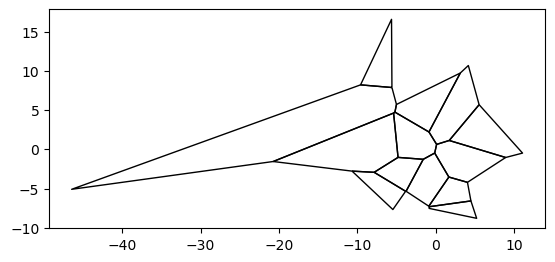

In [104]:
out.plot(ax=plt.gca(), color='None', edgecolor='black')

# Join Voronoi with geodf

In [160]:
bound = gdf.geometry.bounds #Create a large rectangle surrounding it

#Create many points along the rectangle boundary. I create one every 100 m.
boundarycoords = [np.linspace(bound.minx-100, bound.maxx+100, 10), np.linspace(bound.miny-100, bound.maxy+100, 10)]
boundarycoords = np.column_stack(boundarycoords)

boundarycoords
allPoints = np.concatenate((points, boundarycoords))
vorAll = Voronoi(allPoints)

# extract valid polygons
voronoi_polygons = []
clustersPolygons = []

# for i in range(len([region for region in vorAll.regions if region])):
#     if -1 not in vorAll.regions[i]:
#         # Create the polygon for the Voronoi region
#         polygon = Polygon(vorAll.vertices[vorAll.regions[i]])

#         # # Assign the corresponding cluster
#         idx = vorAll.point_region[i]
#         if(idx < num_points):
#             clustersPolygons.append(clusters[idx])
#             voronoi_polygons.append(polygon)

for i in range(num_points):
    idx_region = vorAll.point_region[i]
    if -1 not in vorAll.regions[idx_region]:
        polygon = Polygon(vorAll.vertices[vorAll.regions[idx_region]])
        clustersPolygons.append(clusters[i])
        voronoi_polygons.append(polygon)

# convert to geodataframe
out = gpd.GeoDataFrame(geometry=voronoi_polygons)


In [155]:
vorAll.point_region

array([30, 28, 22, 17, 24, 10, 16, 19, 25, 18, 12, 20, 27, 23, 13, 14,  9,
       29, 21, 26,  5,  4,  7,  6, 15, 11,  8,  3,  1,  2])

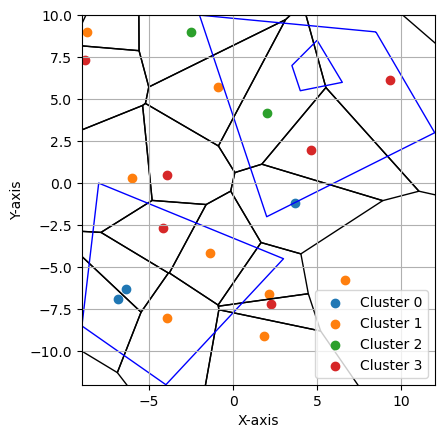

In [164]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

# Scatter plot of the clusters
for cluster_id in range(num_clusters):
    cluster_points = points[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

vorGDF = gpd.GeoDataFrame(geometry=voronoi_polygons)
vorGDF["clusters"] = clustersPolygons
vorGDF.plot(ax=ax, color='None', edgecolor='black')

# GeoDataFrame plot (overlaid)
gdf.plot(ax=plt.gca(), color='None', edgecolor='blue')





# Add labels, legend, and grid
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.xlim(bound.minx[0], bound.maxx[0])
plt.ylim(bound.miny[0], bound.maxy[0])


# Ensure aspect ratio is equal
plt.gca().set_aspect('equal')

# Show the combined plot
plt.show()

In [170]:
vorGDF
merged_gdf = vorGDF.dissolve(by = 'clusters', aggfunc = 'sum').reset_index()
merged_gdf

,clusters,geometry
0,0,"MULTIPOLYGON (((-6.891 -11.277, -22.569 -1.807..."
1,1,"MULTIPOLYGON (((181.781 -278.692, 12.3 -60.863..."
2,2,"POLYGON ((5.523 5.689, 1.709 1.127, 0.1 0.6, -..."
3,3,"MULTIPOLYGON (((-0.8 -7.537, -0.9 -7.326, 4.47..."


# Clip and export

In [171]:
gdf

,geometry,id
0,"MULTIPOLYGON (((-9 -8.5, -8 0, 3 -4.5, -4 -12,...",1


<Axes: >

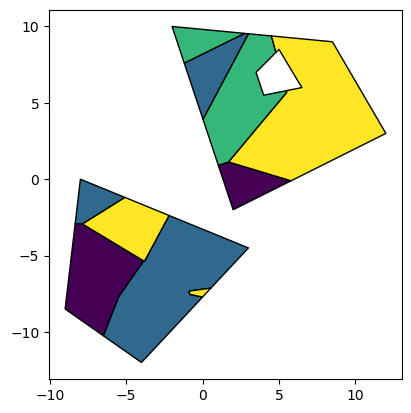

In [173]:
clippedGDF = gpd.clip(merged_gdf, gdf, sort=True)
clippedGDF.plot(column='clusters', edgecolor='black')

# As a function

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import Voronoi

def getVoronoiClipped(points, labels, cadasterGDF):
    bound = cadasterGDF.geometry.bounds #Create a large rectangle surrounding it

    x_bottom_top = np.linspace(bound.minx - 100, bound.maxx + 100, 10)
    y_left_right = np.linspace(bound.miny - 100, bound.maxy + 100, 10)

    bottom_points = np.column_stack([x_bottom_top, np.repeat(bound.miny - 100, 10)])
    top_points = np.column_stack([x_bottom_top, np.repeat(bound.maxy + 100, 10)])
    left_points = np.column_stack([np.repeat(bound.minx - 100, 10), y_left_right])
    right_points = np.column_stack([np.repeat(bound.maxx + 100, 10), y_left_right])

    boundarycoords = np.vstack([bottom_points, top_points, left_points, right_points])
    boundarycoords = np.unique(boundarycoords, axis=0)

    allPoints = np.concatenate((points, boundarycoords))
    vorAll = Voronoi(allPoints)

    # extract valid polygons
    voronoi_polygons = []
    clustersPolygons = []

    for i in range(len(points)):
        idx_region = vorAll.point_region[i]
        if -1 not in vorAll.regions[idx_region]:
            polygon = Polygon(vorAll.vertices[vorAll.regions[idx_region]])
            clustersPolygons.append(labels[i])
            voronoi_polygons.append(polygon)

    vorGDF = gpd.GeoDataFrame(geometry=voronoi_polygons)
    vorGDF["cluster"] = clustersPolygons
    merged_gdf = vorGDF.dissolve(by = 'cluster', aggfunc = 'sum').reset_index()
    clippedGDF = gpd.clip(merged_gdf, cadasterGDF, sort=True)

    return clippedGDF

In [17]:

# Parameters for generating points
num_points = 20  # Total number of points
num_clusters = 4  # Number of clusters
x_range = (-10, 10)  # Range for x-axis
y_range = (-10, 10)  # Range for y-axis

# Generate random points and assign clusters
np.random.seed(42)  # For reproducibility
points = np.random.rand(num_points, 2)
points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]
labels = np.random.randint(0, num_clusters, size=num_points)


# Define the exterior coordinates of the polygons
polygon1_coords = [(-9, -8.5), (-8, 0), (3, -4.5), (-4, -12), (-9, -8.5)]  # A much larger complex polygon
polygon2_coords = [(8.5, 9), (12, 3), (2, -2), (-2, 10), (8.5, 9)]         # A much larger complex polygon
hole_coords = [(5, 8.5), (6.5, 6), (4, 5.5), (3.5, 7), (5, 8.5)]          # Enlarged hole inside polygon2

# Create polygons
polygon1 = Polygon(polygon1_coords)
polygon2 = Polygon(polygon2_coords, [hole_coords])  # Polygon with a hole

# Combine into a MultiPolygon
multipolygon = MultiPolygon([polygon1, polygon2])

# Create a GeoDataFrame
cadasterGDF = gpd.GeoDataFrame([{'geometry': multipolygon, 'id': 1}])

36


<Axes: >

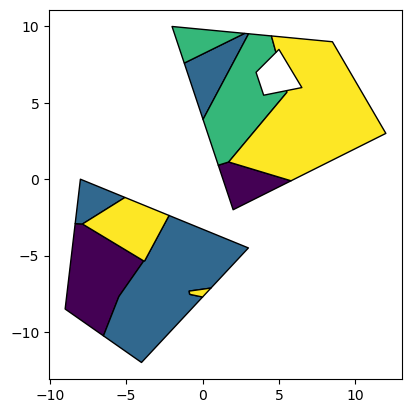

In [20]:
clippedGDF = getVoronoiClipped(points, labels, gdf)
clippedGDF.plot(column='cluster', edgecolor='black')

In [4]:
clippedGDF

,cluster,geometry
0,0,"MULTIPOLYGON (((-7.86278 -2.93309, -3.85235 -5..."
1,1,"MULTIPOLYGON (((-5.47929 -7.68146, -3.85235 -5..."
2,2,"MULTIPOLYGON (((1.70922 1.12726, 1.02802 0.915..."
3,3,"MULTIPOLYGON (((-0.87647 -7.3261, 0.54672 -7.1..."
